## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [1]:
import numpy as np #for numerical operations
import cv2 #for opencv related operations
import pickle #for dumping data
import glob #for file operations
from moviepy.editor import VideoFileClip #for video editing
from IPython.display import HTML #for video displaying on the HTML platform
import matplotlib.pyplot as plt #for image plotting and visualization
from ipywidgets import interact, interactive, fixed #HTML widgets for POC visualization and threshold setting

%matplotlib inline

print('Import Successful...!!!')

Import Successful...!!!


In [2]:
def ImageDisplay(Images,ColorMap=None):
    '''
    Function Name: ImageDisplay
    Parameters : Test Images
    purspose : Visualization
    Return : None
    '''
    # // is the floored-division operator in Python
    cols = 2
    rows = (len(Images)+1)//cols
    plt.figure(figsize=(10,11))
    #setting up the layout to display images
    for iterator, Image in enumerate(Images):
        plt.subplot(rows,cols,iterator+1)
        ColorMap = 'gray' if len(Image.shape)==2 else ColorMap
        plt.imshow(Image,cmap=ColorMap)
        plt.xticks([])
        plt.yticks([])
        plt.savefig('Extrapolated_lines.png')
    plt.tight_layout(pad=0,h_pad=0,w_pad=0)
    plt.show()

## Camera Calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
EmptyObjectPoints = np.zeros((6*9,3), np.float32)
EmptyObjectPoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
ObjectPoints = [] # 3d points in real world space
ImagePoints = [] # 2d points in image plane.

# Make a list of calibration images
Images = glob.glob('./camera_cal/*.jpg')

#Figure, Axes = plt.subplots(5,4, figsize=(16, 11))
#Figure.subplots_adjust(hspace = .2, wspace=.001)
#Axes = Axes.ravel()

# Step through the list and search for chessboard Corners
for Iterator, FileName in enumerate(Images):
    OriginalImage = cv2.imread(FileName)
    GrayImage = cv2.cvtColor(OriginalImage,cv2.COLOR_BGR2GRAY)
    # Find the chessboard Corners
    Return, Corners = cv2.findChessboardCorners(GrayImage, (9,6),None)

    # If found, add object points, image points
    if Return == True:
        ObjectPoints.append(EmptyObjectPoints)

        CornersWithSubPixelAccuracy = cv2.cornerSubPix(GrayImage,Corners,(11,11),(-1,-1),criteria)
        ImagePoints.append(CornersWithSubPixelAccuracy)
    
        # Draw and display the Corners
        OriginalImage = cv2.drawChessboardCorners(OriginalImage, (9,6), Corners, Return)
        #Axes[Iterator].axis('off')
        #Axes[Iterator].imshow(OriginalImage)
        
print('camera calibration successful...!')

camera calibration successful...!


## Undistortion or Image Rectification

Image Rectification successful...!


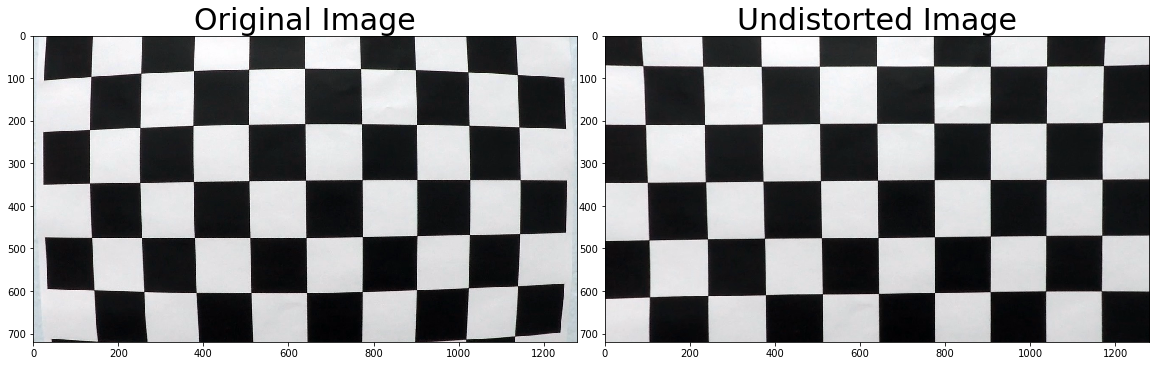

In [5]:
# Test undistortion on an image
OriginalImage = cv2.imread('./camera_cal/calibration1.jpg')
ImageSize = (OriginalImage.shape[1], OriginalImage.shape[0])
#print(OriginalImage.shape)
# Do camera calibration given object points and image points
Return, CameraMatrix, DistortionCoefficients, RotationalVectors, TranslationalVectors = cv2.calibrateCamera(ObjectPoints, ImagePoints, ImageSize,None,None)
UndistortedImage = cv2.undistort(OriginalImage, CameraMatrix, DistortionCoefficients, None, CameraMatrix)

# Dump the camera calibration result
dist_pickle = {}
dist_pickle["CameraMatrix"] = CameraMatrix
dist_pickle["DistortionCoefficients"] = DistortionCoefficients
pickle.dump( dist_pickle, open( "CameraCalibration.p", "wb" ) )

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
File, (Axis_1, Axis_2) = plt.subplots(1, 2, figsize=(20,10))
File.subplots_adjust(hspace = .2, wspace=.05)
Axis_1.imshow(OriginalImage)
Axis_1.set_title('Original Image', fontsize=30)
Axis_2.imshow(UndistortedImage)
Axis_2.set_title('Undistorted Image', fontsize=30)
File.savefig('Undistorted_chessboard.png')
print('Image Rectification successful...!')

In [6]:
def Undistortion(OriginalImage):
    '''
    Function Name: Undistortion
    Parameters : Original Distorted Input Image
    Return : UnDistorted Final Image
    '''
    UndistortedImage = cv2.undistort(OriginalImage,
	CameraMatrix,
	DistortionCoefficients,
	None,
	CameraMatrix)
    return UndistortedImage
print('compiled successfully...!')

compiled successfully...!


input image undistorted successfully


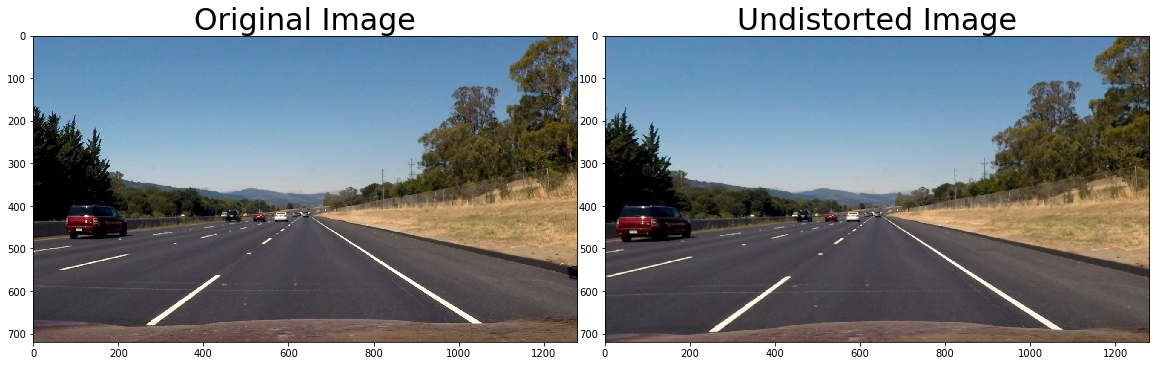

In [7]:
OriginalImage = cv2.imread('./test_images/straight_lines2.jpg')
RGB_Image = cv2.cvtColor(OriginalImage, cv2.COLOR_BGR2RGB)
UndistortedImage = Undistortion(RGB_Image)

# Visualize undistortion
Figure, (Axis_1, Axis_2) = plt.subplots(1, 2, figsize=(20,10))
Figure.subplots_adjust(hspace = .2, wspace=.05)
Axis_1.imshow(RGB_Image)
Axis_1.set_title('Original Image', fontsize=30)
Axis_2.imshow(UndistortedImage)
Axis_2.set_title('Undistorted Image', fontsize=30)
Figure.savefig('Undistorted_TestImage.png')
print('input image undistorted successfully')

## Perspective Transformation

In [8]:
def ImageUnwarp(InputImage, SourcePoints, DestinationPoints):
    Height,Width = InputImage.shape[:2]
    # using cv2.getPerspectiveTransform() to compute the transform matrix, and the inverse transformation matrix
    TransformationMatrix = cv2.getPerspectiveTransform(SourcePoints, DestinationPoints)
    InverseTransformationMatrix = cv2.getPerspectiveTransform(DestinationPoints, SourcePoints)
    # using cv2.warpPerspective() to warp the image to a top-down view
    WarpedImage = cv2.warpPerspective(InputImage,
	TransformationMatrix,
	(Width,Height),
	flags=cv2.INTER_LINEAR)
    return WarpedImage, TransformationMatrix, InverseTransformationMatrix
print('compiled successfully...!')

compiled successfully...!


Undistorted Successfully...!


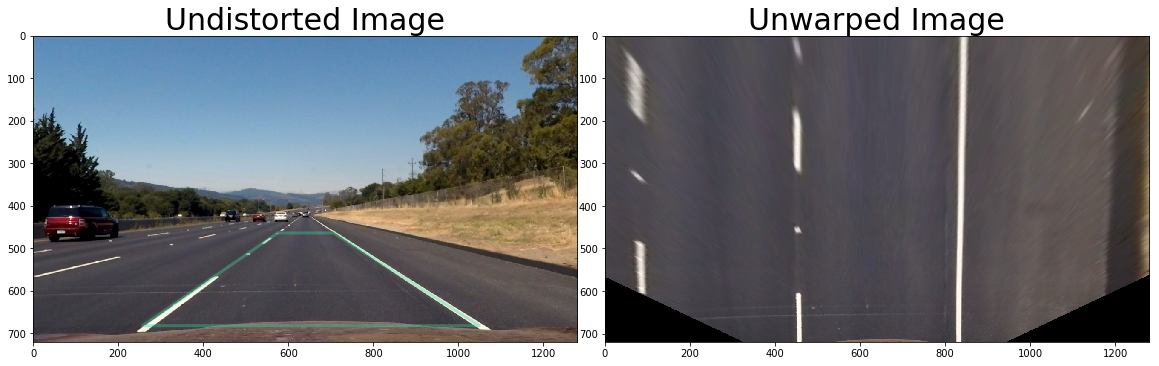

In [9]:
Height,Width = UndistortedImage.shape[:2]

# define source points for transform
LeftTop = (575,464)
RightTop = (707,464)
LeftBottom = (258,682)
RightBottom = (1049,682)


SourcePoints = np.float32([LeftTop,
                  RightTop, 
                  LeftBottom, 
                  RightBottom])
# define destination points for transform

ROI = 450
DestinationPoints = np.float32([(ROI,0),
                  (Width-ROI,0),
                  (ROI,Height),
                  (Width-ROI,Height)])

#unwarping the image
UnwarpedImage, TransformationMatrix, InverseTransformationMatrix = \
								ImageUnwarp(UndistortedImage,
								SourcePoints,
								DestinationPoints)

# Visualizing unwarped image
Figure, (Axis_1, Axis_2) = plt.subplots(1, 2, figsize=(20,10))
Figure.subplots_adjust(hspace = .2, wspace=.05)
Axis_1.imshow(UndistortedImage)
x_axis = [SourcePoints[0][0],SourcePoints[2][0],SourcePoints[3][0],SourcePoints[1][0],SourcePoints[0][0]]
y_axis = [SourcePoints[0][1],SourcePoints[2][1],SourcePoints[3][1],SourcePoints[1][1],SourcePoints[0][1]]
Axis_1.plot(x_axis, y_axis, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
Axis_1.set_ylim([Height,0])
Axis_1.set_xlim([0,Width])
Axis_1.set_title('Undistorted Image', fontsize=30)
Axis_2.imshow(UnwarpedImage)
Axis_2.set_title('Unwarped Image', fontsize=30)
Figure.savefig('Unwarped_TestImage.png')

print('Undistorted Successfully...!')

## Sobel Edge Detection

In [11]:
def Absolute_Sobel_Threshold(InputImage, orient='x', MinimumThreshold=25, MaximumThreshold=255):
    '''
    Function Name: Absolute_Sobel_Threshold
    Parameters : Undistorted InputImage, Min and Max threshold for sobel operation
    purpose : applies sobel operator on the input image
    Return : Edge Detected Binary Image
    '''
   
    #Converting to LAB L channel
    GrayImage = (cv2.cvtColor(InputImage, cv2.COLOR_RGB2Lab))[:,:,0]
    #Taking the derivative in x or y given orient = 'x' or 'y'
    Sobel = cv2.Sobel(GrayImage, cv2.CV_64F, orient=='x', orient=='y')
    # Taking the absolute value of the derivative or gradient
    AbsSobel = np.absolute(Sobel)
    # Scaling to 8-bit (0 - 255) then convert to type = np.uint8
    ScaledSobel = np.uint8(255*AbsSobel/np.max(AbsSobel))
    #Create a mask of 1's where the scaled gradient magnitude 
            # is > MinimumThreshold and < MaximumThreshold
    Sobel_X_Binary = np.zeros_like(ScaledSobel)
    Sobel_X_Binary[(ScaledSobel >= MinimumThreshold) & (ScaledSobel <= MaximumThreshold)] = 1
    #Returning this mask as your BinaryOutput image
    BinaryOutput = Sobel_X_Binary 
    return BinaryOutput
print('Compiled successfully...!')

Compiled successfully...!


## Sobel Magnitude Calculation

In [12]:
def MagnitudeThreshold(Image, SobelKernel=25, MagnitudeThreshold=(25, 255)):
    '''
    Function Name: MagnitudeThreshold
    Parameters : Undistorted InputImage, Min and Max threshold for sobel operation
    purpose : computes the magnitude of the gradient
    Return : Edge Detected Binary Image
    '''
    #Converting to grayscale
    GrayImage = cv2.cvtColor(Image, cv2.COLOR_RGB2GRAY)
    #Taking the derivative in x and y separately
    SobelX = cv2.Sobel(GrayImage, cv2.CV_64F, 1, 0)
    SobelY = cv2.Sobel(GrayImage, cv2.CV_64F, 0, 1)
    # Calculating the magnitude 
    MagnitudeSobel = np.sqrt(np.square(SobelX) + np.square(SobelY))
    # Scaling to 8-bit (0 - 255) then convert to type = np.uint8
    ScaledSobel = np.uint8(255*MagnitudeSobel/np.max(MagnitudeSobel))
    #Creating a binary mask where mag thresholds are met
    Sobel_X_Binary = np.zeros_like(ScaledSobel)
    Sobel_X_Binary[(ScaledSobel >= MagnitudeThreshold[0]) & (ScaledSobel <= MagnitudeThreshold[1])] = 1
    #Returning the mask as BinaryOutput image
    BinaryOutput = np.copy(Sobel_X_Binary) 
    return BinaryOutput
print('Compiled successfully...!')

Compiled successfully...!



## Sobel Direction Calculation

In [13]:
def DirectionThreshold(InputImage, SobelKernel=7, Threshold=(0, 0.09)):
    '''
    Function Name: DirectionThreshold
    Parameters : Undistorted InputImage, SobelKernel and Threshold
    purpose : computes the direction of the gradient
    Return : Edge Detected Binary Image
    '''
    
    # Converting to grayscale
    GrayImage = cv2.cvtColor(InputImage, cv2.COLOR_RGB2GRAY)
    # Taking the gradient in x and y separately
    SobelX = cv2.Sobel(GrayImage, cv2.CV_64F, 1, 0, ksize=SobelKernel)
    SobelY = cv2.Sobel(GrayImage, cv2.CV_64F, 0, 1, ksize=SobelKernel)
    # Taking the absolute value of the x and y gradients
    AbsSobelX = np.absolute(SobelX)
    AbsSobelY = np.absolute(SobelY)
    # Using np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    GradientDirection = np.arctan2(AbsSobelY, AbsSobelX)
    #Creating a binary mask where mag thresholds are met
    BinaryOutput =  np.zeros_like(GradientDirection)
    BinaryOutput[(GradientDirection >= Threshold[0]) & (GradientDirection <= Threshold[1])] = 1
    #Returning the mask as BinaryOutput image
    return BinaryOutput
print('Compiled successfully...!')

Compiled successfully...!


## HLS colour transform S channel

In [14]:
def HLS_S_Threshold(InputImage, Threshold=(125, 255)):
    '''
    Function Name: HLS_S_Threshold
    Parameters : InputImage, Threshold for HLS colour space
    purpose : creates a binary image that thresholds the S-channel of HLS
    Return : Binary Image
    '''
    #Converting to HLS color space
    HLS = cv2.cvtColor(InputImage, cv2.COLOR_RGB2HLS)
    #Applying threshold to the S channel
    BinaryOutput = np.zeros_like(HLS[:,:,2])
    BinaryOutput[(HLS[:,:,2] > Threshold[0]) & (HLS[:,:,2] <= Threshold[1])] = 1
    #Returning a binary image of threshold result
    return BinaryOutput
print('Compiled successfully...!')

Compiled successfully...!


## HLS colour transform L channel

In [15]:
def HLS_L_Threshold(InputImage, Threshold=(220, 255)):
    '''
    Function Name: HLS_L_Threshold
    Parameters : InputImage, Threshold for HLS colour space
    purpose : creates a binary image that thresholds the L-channel of HLS
    Return : Binary Image
    '''
    #Converting to HLS color space
    HLS = cv2.cvtColor(InputImage, cv2.COLOR_RGB2HLS)
    HLS_L = HLS[:,:,1]
    HLS_L = HLS_L*(255/np.max(HLS_L))
    #Applying a threshold to the L channel
    BinaryOutput = np.zeros_like(HLS_L)
    BinaryOutput[(HLS_L > Threshold[0]) & (HLS_L <= Threshold[1])] = 1
    #Returning a binary image of threshold result
    return BinaryOutput
print('Compiled successfully...!')

Compiled successfully...!


## LAB colour transform B channel

In [16]:
def LAB_B_Threshold(InputImage, Threshold=(190,255)):
    '''
    Function Name: LAB_B_Threshold
    Parameters : InputImage, Threshold for LAB colour space
    purpose : creates a binary image that thresholds the B-channel of LAB
              (B channel helps capture yellows region in the input image)
    Return : Binary Image
    '''
    # Converting to LAB color space
    LAB = cv2.cvtColor(InputImage, cv2.COLOR_RGB2Lab)
    LAB_B = LAB[:,:,2]
    # Normalize only if yellow is there in the image
    if np.max(LAB_B) > 175:
        LAB_B = LAB_B*(255/np.max(LAB_B))
    #Applying threshold to the L channel
    BinaryOutput = np.zeros_like(LAB_B)
    BinaryOutput[((LAB_B > Threshold[0]) & (LAB_B <= Threshold[1]))] = 1
    #Returning a binary image of threshold result
    return BinaryOutput
print('Compiled successfully...!')

Compiled successfully...!


## Pipeline for Single Image

In [17]:
def PipeLine(InputImage):
    '''
    Function Name: PipeLine
    Parameters : InputImage (raw image)
    purpose : complete image processing pipeline
    Return : binary image with lane lines isolated from background
    '''
    # Undistorting the input image 
    UndistortedImage = Undistortion(InputImage)
    
    # Applying Perspective Transform
    UnwarpedImage, TransformationMatrix, InverseTransformationMatrix = \
								ImageUnwarp(UndistortedImage,
								SourcePoints,
								DestinationPoints)

    # Sobel Absolute 
    #SobelAbs = Absolute_Sobel_Threshold(UnwarpedImage)

    # Sobel Magnitude 
    #SobelMag = MagnitudeThreshold(UnwarpedImage)
    
    # Sobel Direction 
    #SobelDir = DirectionThreshold(UnwarpedImage)

    # HLS L-channel Threshold
    ImageHLS_LThreshold = HLS_L_Threshold(UnwarpedImage)

    # Lab B-channel Threshold 
    ImageLAB_BThreshold = LAB_B_Threshold(UnwarpedImage)
    
    # Combining L channel of HLS colorspace and B channel of LAB colorspace
    Combined = np.zeros_like(ImageLAB_BThreshold)
    Combined[(ImageHLS_LThreshold == 1) | (ImageLAB_BThreshold == 1)] = 1
    #combined[(SobelAbs == 1) | (SobelDir == 1)] = 1

    return Combined, InverseTransformationMatrix
    
print('Compiled successfully...!')

Compiled successfully...!


Compiled successfully...!


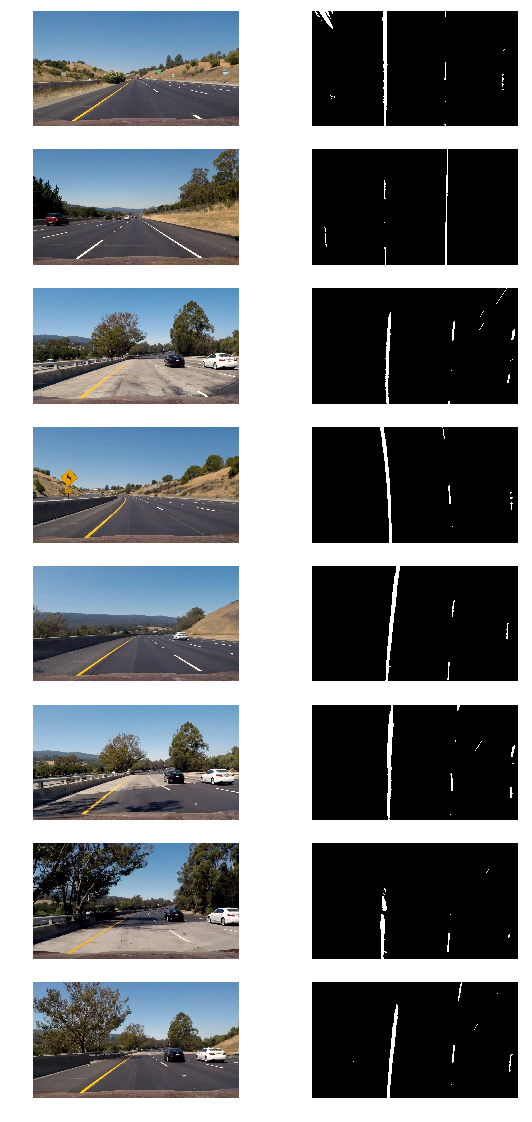

In [18]:
# Make a list of example Images
Images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
Figure, Axis = plt.subplots(len(Images),2, figsize=(10, 20))
Figure.subplots_adjust(hspace = .2, wspace=.001)
Axis = Axis.ravel()
                  
Iterator = 0
for Image in Images:
    InputImage = cv2.imread(Image)
    InputImage = cv2.cvtColor(InputImage, cv2.COLOR_BGR2RGB)
    ImageBinary, InverseTransformationMatrix = PipeLine(InputImage)
    Axis[Iterator].imshow(InputImage)
    Axis[Iterator].axis('off')
    Iterator += 1
    Axis[Iterator].imshow(ImageBinary, cmap='gray')
    Axis[Iterator].axis('off')
    Iterator += 1
Figure.savefig('BinaryThresholding.jpg')
print('Compiled successfully...!')

## Sliding window Polyfit

In [19]:
def SlidingWindowPolyfit(InputImage):
    '''
    Function Name: SlidingWindowPolyfit
    Parameters : InputImage (raw image)
    purpose : to fit polynomial to binary image with lines extracted, using sliding Window
    Return : output image with lane detected in the form of sliding windows
    '''
    # Histogram of the bottom half of the image
    Histogram = np.sum(InputImage[InputImage.shape[0]//2:,:], axis=0)
    Midpoint = np.int(Histogram.shape[0]//2)
    QuaterPoint = np.int(Midpoint//2)
    #print(QuaterPoint)
    #quarter of the Histogram (directly to the left/right) is considered
    Left_X_Base = np.argmax(Histogram[QuaterPoint:Midpoint]) + QuaterPoint
    #QuaterPoint = 0
    #Left_X_Base = np.argmax(Histogram[QuaterPoint:Midpoint]) + QuaterPoint

    #print(np.argmax(Histogram[QuaterPoint:Midpoint]))
    Right_X_Base = np.argmax(Histogram[Midpoint:(Midpoint+QuaterPoint)]) + Midpoint
    #Right_X_Base = np.argmax(Histogram[Midpoint:]) 

    #print(np.argmax(Histogram[Midpoint:]))
    
    #print('base pts:', Left_X_Base, Right_X_Base)

    #number of sliding windows
    TotalWindows = 9
    #height of windows
    WindowHeight = np.int(InputImage.shape[0]/TotalWindows)
    # Identifying the x and y positions of all NonZero pixels in the image
    NonZero = InputImage.nonzero()
    NonZeroY = np.array(NonZero[0])
    NonZeroX = np.array(NonZero[1])
    #print(NonZeroX,NonZeroY)
    #updating Current positions for each Window
    Left_X_Current = Left_X_Base
    Right_X_Current = Right_X_Base
    # Setting the width of the windows +/- Margin
    Margin = 80
    # Setting minimum number of pixels found to recenter Window
    MinimumPixels = 40
    # Creating empty lists to receive left and right lane pixel indices
    Left_Lane_Indices = []
    Right_Lane_Indices = []
    #data for visualization
    RectangleData = []
    
    # Steping through the windows one by one
    for Window in range(TotalWindows):
        # Identify Window boundaries in x and y (and right and left)
        WinY_Low = (InputImage.shape[0] - (Window+1)*WindowHeight) + 1
        WinY_High = (InputImage.shape[0] - Window*WindowHeight) + 1
        #print(WinY_Low,WinY_High)
        Win_Xleft_Low = Left_X_Current - Margin
        Win_Xleft_High = Left_X_Current + Margin
        #print(Window,Win_Xleft_Low,Win_Xleft_High)
        Win_Xright_Low = Right_X_Current - Margin
        Win_Xright_High = Right_X_Current + Margin
        RectangleData.append((WinY_Low, WinY_High, Win_Xleft_Low, Win_Xleft_High, Win_Xright_Low, Win_Xright_High))
        # Identify the NonZero pixels in x and y within the Window
        Good_LeftIndices = ((NonZeroY >= WinY_Low) & (NonZeroY < WinY_High) & (NonZeroX >= Win_Xleft_Low) & (NonZeroX < Win_Xleft_High)).nonzero()[0]
        Good_RightIndices = ((NonZeroY >= WinY_Low) & (NonZeroY < WinY_High) & (NonZeroX >= Win_Xright_Low) & (NonZeroX < Win_Xright_High)).nonzero()[0]
        #print(Good_LeftIndices)
        # Append these indices to the lists
        Left_Lane_Indices.append(Good_LeftIndices)
        Right_Lane_Indices.append(Good_RightIndices)
        # If found > MinimumPixels pixels, recenter next Window on their mean position
        if len(Good_LeftIndices) > MinimumPixels:
            Left_X_Current = np.int(np.mean(NonZeroX[Good_LeftIndices]))
        if len(Good_RightIndices) > MinimumPixels:        
            Right_X_Current = np.int(np.mean(NonZeroX[Good_RightIndices]))

    # Concatenate the arrays of indices
    Left_Lane_Indices = np.concatenate(Left_Lane_Indices)
    Right_Lane_Indices = np.concatenate(Right_Lane_Indices)

    # Extract left and right line pixel positions
    LeftX = NonZeroX[Left_Lane_Indices]
    LeftY = NonZeroY[Left_Lane_Indices] 
    RightX = NonZeroX[Right_Lane_Indices]
    RightY = NonZeroY[Right_Lane_Indices] 

    LeftFit, RightFit = (None, None)
    # Fitting a second order polynomial to each
    if len(LeftX) != 0:
        LeftFit = np.polyfit(LeftY, LeftX, 2)
    if len(RightX) != 0:
        RightFit = np.polyfit(RightY, RightX, 2)
    
    visualization_data = (RectangleData, Histogram)
    
    return LeftFit, RightFit, Left_Lane_Indices, Right_Lane_Indices, visualization_data

print('compiled successfully...!')
    

compiled successfully...!


## Sliding window visualization

Sliding window plotting successful..!


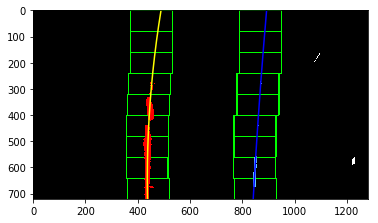

In [31]:
# visualizing the result on example image
InputImage = cv2.imread('./test_images/test5.jpg')
InputImage = cv2.cvtColor(InputImage, cv2.COLOR_BGR2RGB)
ImageBinary, InverseTransformationMatrix = PipeLine(InputImage)
    
LeftFit, RightFit, Left_Lane_Indices, Right_Lane_Indices, visualization_data = SlidingWindowPolyfit(ImageBinary)

Height = InputImage.shape[0]
left_fit_x_int = LeftFit[0]*Height**2 + LeftFit[1]*Height + LeftFit[2]
right_fit_x_int = RightFit[0]*Height**2 + RightFit[1]*Height + RightFit[2]


Rectangles = visualization_data[0]
Histogram = visualization_data[1]

# Creating an output image for visualization
OutputImage = np.uint8(np.dstack((ImageBinary, ImageBinary, ImageBinary))*255)
# Generating x and y values to plot
PlotY = np.linspace(0, ImageBinary.shape[0]-1, ImageBinary.shape[0] )
#print(PlotY)
Left_FitX = LeftFit[0]*PlotY**2 + LeftFit[1]*PlotY + LeftFit[2]
Right_fitX = RightFit[0]*PlotY**2 + RightFit[1]*PlotY + RightFit[2]
for rect in Rectangles:
# Drawing the windows on the visualization image
    cv2.rectangle(OutputImage,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
    cv2.rectangle(OutputImage,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 
# Identifying the x and y positions of all nonzero pixels in the image
nonzero = ImageBinary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
OutputImage[nonzeroy[Left_Lane_Indices], nonzerox[Left_Lane_Indices]] = [255, 0, 0]
OutputImage[nonzeroy[Right_Lane_Indices], nonzerox[Right_Lane_Indices]] = [100, 200, 255]
plt.imshow(OutputImage)
plt.plot(Left_FitX, PlotY, color='yellow')
plt.plot(Right_fitX, PlotY, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('SlidingWindow.jpg')
print('Sliding window plotting successful..!')


## Histogram Calculation

Histogram plotting successful..!


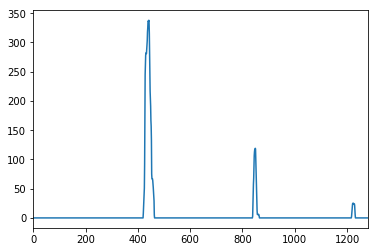

In [32]:
# Histogram from sliding window polyfit for the Input Image
plt.plot(Histogram)
plt.xlim(0, 1280)
plt.savefig('Histogram.jpg')
print('Histogram plotting successful..!')

## fitting polynomial visualization

In [33]:
def Polyfit_PreviousData(WarpedBinary, Left_FitPrevious, Right_FitPrevious):
    '''
    Function Name: Polyfit_PreviousData
    Parameters : InputImage (raw image),PreviousFit Data of left and right lanes
    purpose : to fit polynomial to binary image based upon a previous fit
    Return : output image with lane detected in the form of sliding windows
    '''
    nonzero = WarpedBinary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    Margin = 80
    Left_Lane_Indices = ((nonzerox > (Left_FitPrevious[0]*(nonzeroy**2) + Left_FitPrevious[1]*nonzeroy + Left_FitPrevious[2] - Margin)) & 
                      (nonzerox < (Left_FitPrevious[0]*(nonzeroy**2) + Left_FitPrevious[1]*nonzeroy + Left_FitPrevious[2] + Margin))) 
    Right_Lane_Indices = ((nonzerox > (Right_FitPrevious[0]*(nonzeroy**2) + Right_FitPrevious[1]*nonzeroy + Right_FitPrevious[2] - Margin)) & 
                       (nonzerox < (Right_FitPrevious[0]*(nonzeroy**2) + Right_FitPrevious[1]*nonzeroy + Right_FitPrevious[2] + Margin)))  

    # extracting left and right line pixel positions
    LeftX = nonzerox[Left_Lane_Indices]
    lefty = nonzeroy[Left_Lane_Indices] 
    rightx = nonzerox[Right_Lane_Indices]
    righty = nonzeroy[Right_Lane_Indices]
    
    Left_Fit_New, Right_Fit_New = (None, None)
    if len(LeftX) != 0:
        # Fitting a second order polynomial to each
        Left_Fit_New = np.polyfit(lefty, LeftX, 2)
    if len(rightx) != 0:
        Right_Fit_New = np.polyfit(righty, rightx, 2)
    return Left_Fit_New, Right_Fit_New, Left_Lane_Indices, Right_Lane_Indices
print('compiled successfully..!')

compiled successfully..!


...


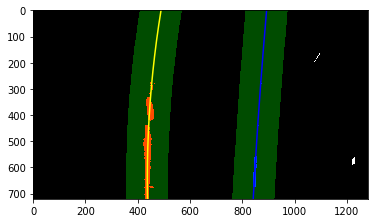

In [34]:
# visualizing the result on test image
InputImage = cv2.imread('./test_images/test5.jpg')
InputImage = cv2.cvtColor(InputImage, cv2.COLOR_BGR2RGB)
BinaryImage2, InversePerspectiveTransform = PipeLine(InputImage)   
Margin = 80

Left_Fit_Previous, Right_Fit_Previous, Left_Lane_Indices_Previous, Right_Lane_Indices_Previous = Polyfit_PreviousData(BinaryImage2, LeftFit, RightFit)

# Generating x and y values for plotting
PlotY = np.linspace(0, BinaryImage2.shape[0]-1, BinaryImage2.shape[0] )
Left_FitX = LeftFit[0]*PlotY**2 + LeftFit[1]*PlotY + LeftFit[2]
Right_FitX = RightFit[0]*PlotY**2 + RightFit[1]*PlotY + RightFit[2]
Left_FitX_Previous = Left_Fit_Previous[0]*PlotY**2 + Left_Fit_Previous[1]*PlotY + Left_Fit_Previous[2]
Right_FitX_Previous = Right_Fit_Previous[0]*PlotY**2 + Right_Fit_Previous[1]*PlotY + Right_Fit_Previous[2]

# Creating an image to draw on and an image to show the selection window
OutputImage = np.uint8(np.dstack((BinaryImage2, BinaryImage2, BinaryImage2))*255)
WindowImage = np.zeros_like(OutputImage)

# Coloring the left and right line pixels
nonzero = BinaryImage2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
OutputImage[nonzeroy[Left_Lane_Indices_Previous], nonzerox[Left_Lane_Indices_Previous]] = [255, 0, 0]
OutputImage[nonzeroy[Right_Lane_Indices_Previous], nonzerox[Right_Lane_Indices_Previous]] = [0, 0, 255]

# Generating a polygon to illustrate the search window area (OLD FIT)
Left_Line_Window1 = np.array([np.transpose(np.vstack([Left_FitX-Margin, PlotY]))])
Left_Line_Window2 = np.array([np.flipud(np.transpose(np.vstack([Left_FitX+Margin, PlotY])))])
Left_Line_Points = np.hstack((Left_Line_Window1, Left_Line_Window2))
Right_Line_Window1 = np.array([np.transpose(np.vstack([Right_FitX-Margin, PlotY]))])
Right_Line_Window2 = np.array([np.flipud(np.transpose(np.vstack([Right_FitX+Margin, PlotY])))])
Right_Line_Points = np.hstack((Right_Line_Window1, Right_Line_Window2))

# Drawing the lane onto the warped blank image
cv2.fillPoly(WindowImage, np.int_([Left_Line_Points]), (0,255, 0))
cv2.fillPoly(WindowImage, np.int_([Right_Line_Points]), (0,255, 0))
result = cv2.addWeighted(OutputImage, 1, WindowImage, 0.3, 0)
plt.imshow(result)
plt.plot(Left_FitX_Previous, PlotY, color='yellow')
plt.plot(Right_FitX_Previous, PlotY, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('PolyFill.jpg')
print('...')

## Radius of curvature and distance from lane center estimation

In [35]:
def CurvatureRadius_and_CenterDistance_Calculation(BinaryImage, LeftFit, RightFit, LeftLane_Indices, RightLane_Indices):
    '''
    Function Name: CurvatureRadius_and_CenterDistance_Calculation
    Parameters : InputImage (binary image),Left and Right fit and their corresponding pixel indices
    purpose : to determine radius of curvature and distance from lane center
    Return : Radius of curvature and Distance from lane center
    '''
    # Defining conversions in x and y from pixels space to meters
    Yaxis_MetersPerPixel = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    Xaxis_MetersPerPixel = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    LeftCurveRadius, RightCurveRadius, CenterDistance = (0, 0, 0)
    # Defining y-value where we want radius of curvature
    Height = BinaryImage.shape[0]
    PlotY = np.linspace(0, Height-1, Height)
    Y_Eval = np.max(PlotY)
  
    # Identifying the x and y positions of all nonzero pixels in the image
    nonzero = BinaryImage.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # extract left and right line pixel positions
    LeftX = nonzerox[LeftLane_Indices]
    LeftY = nonzeroy[LeftLane_Indices] 
    RightX = nonzerox[RightLane_Indices]
    RightY = nonzeroy[RightLane_Indices]
    
    if len(LeftX) != 0 and len(RightX) != 0:
        # Fitting new polynomials to x,y in world space
        LeftFitCurve = np.polyfit(LeftY*Yaxis_MetersPerPixel, LeftX*Xaxis_MetersPerPixel, 2)
        RightFitCurve = np.polyfit(RightY*Yaxis_MetersPerPixel, RightX*Xaxis_MetersPerPixel, 2)
        # Calculating the new radii of curvature
        LeftCurveRadius = ((1 + (2*LeftFitCurve[0]*Y_Eval*Yaxis_MetersPerPixel + LeftFitCurve[1])**2)**1.5) / np.absolute(2*LeftFitCurve[0])
        RightCurveRadius = ((1 + (2*RightFitCurve[0]*Y_Eval*Yaxis_MetersPerPixel + RightFitCurve[1])**2)**1.5) / np.absolute(2*RightFitCurve[0])
        
    
    # Distance from center is image x midpoint - mean of LeftFit and RightFit intercepts 
    if RightFit is not None and LeftFit is not None:
        car_position = BinaryImage.shape[1]/2
        LeftFit_Xint = LeftFit[0]*Height**2 + LeftFit[1]*Height + LeftFit[2]
        RightFit_Xint = RightFit[0]*Height**2 + RightFit[1]*Height + RightFit[2]
        LaneCenterPosition = (RightFit_Xint + LeftFit_Xint) /2
        CenterDistance = (car_position - LaneCenterPosition) * Xaxis_MetersPerPixel
    return LeftCurveRadius, RightCurveRadius, CenterDistance
print('compiled successfully..!')

RadiusLeft, RadiusRight, DistanceToCenter = CurvatureRadius_and_CenterDistance_Calculation(ImageBinary, LeftFit, RightFit, Left_Lane_Indices, Right_Lane_Indices)

print('Radius of curvature for example:', RadiusLeft, 'm,', RadiusRight, 'm')
print('Distance from lane center for example:', DistanceToCenter, 'm')

compiled successfully..!
Radius of curvature for example: 375.53524064234665 m, 2167.27979696653 m
Distance from lane center for example: 0.00407763454079426 m


## Drawing Lane based on estimated Data

compiled successfully..!


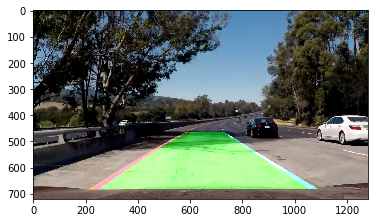

In [36]:
def DrawLane(OriginalImage, BinaryImage, LeftFit, RightFit, InverseTransformationMatrix):
    '''
    Function Name: DrawLane
    Parameters : OriginalImage,BinaryImage,Left and Right fit and InverseTransformationMatrix
    purpose : To Visualize the detected lane
    Return : Lane Detected Image without radius of curvature and distance from lane center
    '''
    new_img = np.copy(OriginalImage)
    if LeftFit is None or RightFit is None:
        return OriginalImage
    # an empty image to draw the lines on
    WarpZero = np.zeros_like(BinaryImage).astype(np.uint8)
    ColorWarp = np.dstack((WarpZero, WarpZero, WarpZero))
    
    Height,Weight = BinaryImage.shape
    ploty = np.linspace(0, Height-1, num=Height)# to cover same y-range as image
    LeftFitX = LeftFit[0]*ploty**2 + LeftFit[1]*ploty + LeftFit[2]
    Right_FitX = RightFit[0]*ploty**2 + RightFit[1]*ploty + RightFit[2]

    # Recasting the x and y points into usable format for cv2.fillPoly()
    Pts_Left = np.array([np.transpose(np.vstack([LeftFitX, ploty]))])
    Pts_Right = np.array([np.flipud(np.transpose(np.vstack([Right_FitX, ploty])))])
    Pts = np.hstack((Pts_Left, Pts_Right))

    # Drawing the lane onto the warped blank image
    cv2.fillPoly(ColorWarp, np.int_([Pts]), (0,255, 0))
    cv2.polylines(ColorWarp, np.int32([Pts_Left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(ColorWarp, np.int32([Pts_Right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warping the blank back to original image space using inverse perspective matrix (InverseTransformationMatrix)
    NewWarp = cv2.warpPerspective(ColorWarp, InverseTransformationMatrix, (Weight, Height)) 
    # Combining the Result with the original image
    Result = cv2.addWeighted(new_img, 1, NewWarp, 0.5, 0)
    return Result
print('compiled successfully..!')
OutputImage = DrawLane(InputImage, ImageBinary, LeftFit, RightFit, InversePerspectiveTransform)
plt.imshow(OutputImage)
plt.savefig('LaneDetectionWithoutData.jpg')

## Drawing Lane based on estimated Data

compiled successfully..!


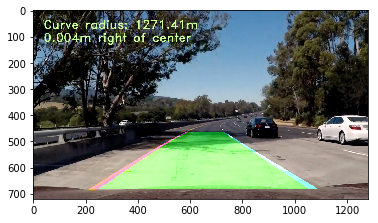

In [37]:
def DrawLaneWithData(OriginalImage, CurveRadius, CenterDistance):
    '''
    Function Name: DrawLaneWithData
    Parameters : OriginalImage,radius of curvature and distance from lane center
    purpose : To Visualize the detected lane with plotted data
    Return : Lane Detected Image with radius of curvature and distance from lane center
    '''
    NewImage = np.copy(OriginalImage)
    Height = NewImage.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(CurveRadius) + 'm'
    cv2.putText(NewImage, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    Direction = ''
    if CenterDistance > 0:
        Direction = 'right'
    elif CenterDistance < 0:
        Direction = 'left'
    Abs_Center_Distance = abs(CenterDistance)
    text = '{:04.3f}'.format(Abs_Center_Distance) + 'm ' + Direction + ' of center'
    cv2.putText(NewImage, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return NewImage
print('compiled successfully..!')
OutputImageModified = DrawLaneWithData(OutputImage, (RadiusLeft+RadiusRight)/2, DistanceToCenter)
plt.imshow(OutputImageModified)
plt.savefig('LaneDetectionWithData.jpg')

## Defining Class for Line Detection

In [38]:
class LaneLine():
    '''
    Class Name: LaneLine()
    Parameters : None
    purpose : to receive the characteristics of each line detection
    Return : none
    '''
    def __init__(self):
        
        self.Detected = False  #to ensurse the line detection in previous line
        
        self.Recent_Xfitted = [] # x values of the last n fits of the line
        #average x values of the fitted line over the last n iterations
        self.BestX = None     
        #polynomial coefficients averaged over the last n iterations
        self.Best_Fit = None  
        #polynomial coefficients for the most recent fit
        self.Current_Fit = []  
        #radius of curvature of the line in some units
        self.Radius_Of_Curvature = None 
        #distance in meters of vehicle center from the line
        self.Line_Base_Pos = None 
        #difference in fit coefficients between last and new fits
        self.Difference = np.array([0,0,0], dtype='float') 
        #number of Detected pixels
        self.PixelCount = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.Best_Fit is not None:
                # if we have a best fit, see how this new fit compares
                self.Difference = abs(fit-self.Best_Fit)
            if (self.Difference[0] > 0.001 or \
               self.Difference[1] > 1.0 or \
               self.Difference[2] > 100.) and \
               len(self.Current_Fit) > 0:
                self.Detected = False
            else:
                self.Detected = True
                self.PixelCount = np.count_nonzero(inds)
                self.Current_Fit.append(fit)
                if len(self.Current_Fit) > 5:
                    # discard old fits, keep newest n
                    self.Current_Fit = self.Current_Fit[len(self.Current_Fit)-5:]
                self.Best_Fit = np.average(self.Current_Fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.Detected = False
            if len(self.Current_Fit) > 0:
                # throw out oldest fit
                self.Current_Fit = self.Current_Fit[:len(self.Current_Fit)-1]
            if len(self.Current_Fit) > 0:
                # if there are still any fits in the queue, Best_Fit is their average
                self.Best_Fit = np.average(self.Current_Fit, axis=0)


            
def PolyFitOntoImage(InputImage, Fit, PlotColor):
    '''
    Class Name: PolyFitOntoImage()
    Parameters : InputImage,Fit,color 
    purpose : visualization of the plot data
    Return : the plotted image
    '''
    if Fit is None:
        return InputImage
    NewImage = np.copy(InputImage)
    Height = NewImage.shape[0]
    PlotY = np.linspace(0, Height-1, Height)
    PlotX = Fit[0]*PlotY**2 + Fit[1]*PlotY + Fit[2]
    Points = np.array([np.transpose(np.vstack([PlotX, PlotY]))])
    cv2.polylines(NewImage, np.int32([Points]), isClosed=False, color=PlotColor, thickness=8)
    return NewImage
print('compiled successfully...!')

compiled successfully...!


## Processing on a single image

In [41]:
def ProcessImage(InputImage):
    '''
    Class Name: ProcessImage()
    Parameters : InputImage
    purpose : Detect the lane, estimate the radius of the curvature, distance from centre and plotting
    Return : the plotted image
    '''
    NewImage = np.copy(InputImage)
    BinaryImage, InverseTransformationMatrix = PipeLine(NewImage)
    
    # using Polyfit_PreviousData if both left and right lines were detected last frame, 
    # otherwise using SlidingWindowPolyfit
    if not LeftLine.Detected or not RightLine.Detected:
        LeftFit, RightFit, LeftLane_Indices, RightLane_Indices, _ = SlidingWindowPolyfit(BinaryImage)
    else:
        LeftFit, RightFit, LeftLane_Indices, RightLane_Indices = Polyfit_PreviousData(BinaryImage, LeftLine.Best_Fit, RightLine.Best_Fit)
        
    
    if LeftFit is not None and RightFit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        Height = InputImage.shape[0]
        LeftFit_X = LeftFit[0]*Height**2 + LeftFit[1]*Height + LeftFit[2]
        RightFit_X = RightFit[0]*Height**2 + RightFit[1]*Height + RightFit[2]
        X_difference = abs(RightFit_X-LeftFit_X)
        if abs(350 - X_difference) > 100:
            LeftFit = None
            RightFit = None
            
    LeftLine.add_fit(LeftFit, LeftLane_Indices)
    RightLine.add_fit(RightFit, RightLane_Indices)
    
    # draw the current best fit if it exists
    if LeftLine.Best_Fit is not None and RightLine.Best_Fit is not None:
        OutputImage = DrawLane(NewImage, BinaryImage, LeftLine.Best_Fit, RightLine.Best_Fit, InverseTransformationMatrix)
        LeftRadius, RightRadius, DistanceCenter = CurvatureRadius_and_CenterDistance_Calculation(BinaryImage, LeftLine.Best_Fit, RightLine.Best_Fit, 
                                                               LeftLane_Indices, RightLane_Indices)
        DisplayImage = DrawLaneWithData(OutputImage, (LeftRadius+RightRadius)/2, DistanceCenter)
    else:
        DisplayImage = NewImage
    
    return DisplayImage
print('compiled successfully...!')

compiled successfully...!


In [42]:
LeftLine = LaneLine()
RightLine = LaneLine()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(ProcessImage)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:57<00:00,  5.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))